##### 0. Setup Colab and Google-Drive.

In [1]:
%cd /content/drive/MyDrive/Computer\ Vision/Instance\ Segmentation

/content/drive/MyDrive/Computer Vision/Instance Segmentation


##### 1. Setup for downloading dataset from kaggle.

In [2]:
from google.colab import files
files.upload() 

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
# search for dataset in kaggle.
!kaggle datasets list -s "COVID-19 Radiography Database"

ref                                                           title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
tawsifurrahman/covid19-radiography-database                   COVID-19 Radiography Database                     778MB  2022-03-19 13:38:42          59721        790  1.0              
andyczhao/covidx-cxr2                                         COVIDx CXR-2                                       13GB  2022-06-02 13:22:23           6381        156  0.875            
anasmohammedtahir/covidqu                                     COVID-QU-Ex Dataset                                 1GB  2022-02-01 06:23:01           2159         45  0.6875           
mloey1/covid19-chest-ct-image-augmentation-gan-dataset        COVID-19 Chest CT 

##### 2. Download dataset from kaggle.

In [4]:
import os

zipfile_path = os.path.join("/", "home")
!kaggle datasets download --force -d tawsifurrahman/covid19-radiography-database -p {zipfile_path}

100% 777M/778M [00:32<00:00, 27.2MB/s]
100% 778M/778M [00:33<00:00, 24.7MB/s]


##### 3. Extract Dataset.

In [5]:
from zipfile import ZipFile

zipfile_name = "covid19-radiography-database.zip"
dataset = os.path.join(zipfile_path, zipfile_name)

with ZipFile(dataset, "r") as zip:
    # exctract in same path as zipfile
    zip.extractall(zipfile_path)

print(os.listdir(zipfile_path))

['COVID-19_Radiography_Dataset', 'covid19-radiography-database.zip']


##### 4. Setup Paths.

In [6]:
# Sine we are just intrested in instance-segementation here,  we do not care about the class of images.
# So we move all images into a same folder and move their masks to another folder.
import shutil
from tqdm import tqdm

paths = {
    "images": os.path.join("/", "home", "images"),
    "masks" : os.path.join("/", "home", "masks"),
}

for fname, path in paths.items():
    os.makedirs(path, exist_ok=True)
    print(f"folder `{fname}` created.")

current_folders = {
    "COVID"           : os.path.join("/", "home", "COVID-19_Radiography_Dataset", "COVID"),
    "Lung_Opacity"    : os.path.join("/", "home", "COVID-19_Radiography_Dataset", "Lung_Opacity"),
    "Normal"          : os.path.join("/", "home", "COVID-19_Radiography_Dataset", "Normal"),
    "Viral_Pneumonia" : os.path.join("/", "home", "COVID-19_Radiography_Dataset", "Viral Pneumonia"),
}
print("paths were set.")

folder `images` created.
folder `masks` created.
paths were set.


##### 5. Move Images.

In [7]:
for folder_name, path in current_folders.items():
    print(f"*** Moving images of `{folder_name}` ***")
    for subfolder in ("images", "masks"):
        print(f"{subfolder}...", end=" ")
        subpath = os.path.join(path, subfolder)
        files = os.listdir(subpath)
        files = [os.path.join(subpath, f) for f in files]
        for f in tqdm(files):
            shutil.move(f, paths[subfolder])
    
    print("done.")
    print()

*** Moving images of `COVID` ***
images... 

100%|██████████| 3616/3616 [00:00<00:00, 19717.40it/s]


masks... 

100%|██████████| 3616/3616 [00:00<00:00, 20440.55it/s]


done.

*** Moving images of `Lung_Opacity` ***
images... 

100%|██████████| 6012/6012 [00:00<00:00, 20305.58it/s]


masks... 

100%|██████████| 6012/6012 [00:00<00:00, 19872.72it/s]


done.

*** Moving images of `Normal` ***
images... 

100%|██████████| 10192/10192 [00:00<00:00, 21257.89it/s]


masks... 

100%|██████████| 10192/10192 [00:00<00:00, 21132.75it/s]


done.

*** Moving images of `Viral_Pneumonia` ***
images... 

100%|██████████| 1345/1345 [00:00<00:00, 21297.31it/s]


masks... 

100%|██████████| 1345/1345 [00:00<00:00, 20894.23it/s]

done.



##### 6. Visualize some sample images.

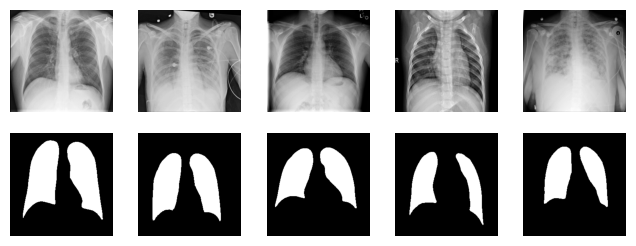

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from random import sample
from matplotlib.pyplot import figure

def load_img(path: str):
    img = Image.open(path)
    img.load()
    data = np.asarray(img, dtype="int32")
    return data

num_samples = 5
samples = sample(os.listdir(paths["images"]), num_samples)

figure(figsize=(8, 3), dpi=100)
for i in range(num_samples):
    img = load_img(os.path.join(paths["images"], samples[i]))
    mask = load_img(os.path.join(paths["masks"], samples[i]))
    plt.subplot(2, num_samples, i+1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")

    plt.subplot(2, num_samples, i+num_samples+1)
    plt.imshow(mask)
    plt.axis("off")

##### 7. Create tf-dataset.

In [9]:
import tensorflow as tf

width, height  = 256, 256
batch_size = 32

train_imgs = tf.keras.utils.image_dataset_from_directory(
    paths['images'],
    color_mode="grayscale",
    seed=1,
    image_size=(width, height),
    batch_size=batch_size,
    validation_split=0.1,
    subset="training",
    shuffle=False,
    label_mode=None,
)
print()
train_masks = tf.keras.utils.image_dataset_from_directory(
    paths['masks'],
    color_mode="rgb",
    seed=1,
    image_size=(width, height),
    batch_size=batch_size,
    validation_split=0.1,
    subset="training",
    shuffle=False,
    label_mode=None,
)
print()
valid_imgs = tf.keras.utils.image_dataset_from_directory(
    paths['images'],
    color_mode="grayscale",
    seed=1,
    image_size=(width, height),
    batch_size=batch_size,
    validation_split=0.1,
    subset="validation",
    shuffle=False,
    label_mode=None,
)
print()
valid_masks = tf.keras.utils.image_dataset_from_directory(
    paths['masks'],
    color_mode="rgb",
    seed=1,
    image_size=(width, height),
    batch_size=batch_size,
    validation_split=0.1,
    subset="validation",
    shuffle=False,
    label_mode=None,
)

train_ds = tf.data.Dataset.zip((train_imgs, train_masks))
valid_ds = tf.data.Dataset.zip((valid_imgs, valid_masks))

Found 21165 files belonging to 1 classes.
Using 19049 files for training.

Found 21165 files belonging to 1 classes.
Using 19049 files for training.

Found 21165 files belonging to 1 classes.
Using 2116 files for validation.

Found 21165 files belonging to 1 classes.
Using 2116 files for validation.


##### 9. Preprocessing.

In [10]:
train_ds = train_ds.map(lambda x, y: (x/255., y/255.)).prefetch(1)
valid_ds = valid_ds.map(lambda x, y: (x/255., y/255.)).prefetch(1)